### Flight

Flights File - flight details from Eurocontrol Network Manager flight plans in PRISME Data Warehouse (DWH)

The data is in a CSV file with the following columns:
- `ECTL_ID`: Unique numeric identifier for each flight in Eurocontrol PRISME DWH
- `ADEP`: ICAO airport code for the departure airport of the flight. The ICAO airport code or location indicator is a four-letter alphanumeric code designating each airport around the world. These codes are defined by the International Civil Aviation Organization, and published in ICAO Document 7910: Location Indicators.
- `ADEP`: LatitudeLatitude of departure airport in decimal degrees.
- `ADEP`: LongitudeLongitude of departure airport in decimal degrees.
- `ADES`:ICAO airport code for the destination airport of the flight. The ICAO airport code or location indicator is a four-letter alphanumeric code designating each airport around the world. These codes are defined by the International Civil Aviation Organization, and published in ICAO Document 7910: Location Indicators. If a flight is diverted, then the ADES will be the actual airport where it landed.
- `ADES Latitude`: Latitude of destination airport in decimal degrees.
- `ADES Latitude`: Latitude of destination airport in decimal degrees.
- `Filed Arrival Time`: Time of arrival (UTC) based on the last filed flight plan. It is the time at which the aircraft will land at the aerodrome according to the planned profile calculated for the flight.
- `Actual Off-Block Time`: Off-Block Time (UTC) based on the ATFM-updated flight plan. The time that an aircraft departs from its parking position. This time may be known from flight data updates received by NM, or in the absence of such updates may be calculated from the known take-off time minus a standard taxi time value for the airport.
- `Actual Arrival Time`: Time of arrival (UTC) based on the ATFM-updated flight plan. It is the time at which the aircraft lands at the aerodrome, reflecting the best picture that NM has based on available radar updates, ATFM messages received etc.
- `AC Type`: The ICAO aircraft type designator is a two-, three- or four-character alphanumeric code designating every aircraft type that may appear in flight planning. These codes are defined by the International Civil Aviation Organization, and published in ICAO Document 8643 Aircraft Type Designators.
- `AC Operator`: Three-letter ICAO operator code. Aircraft operator codes are defined by ICAO and published in Document 8585. If the operator is unknown, not provided in the flight plan or not present in Document 8585 the value will be "ZZZ".
- `AC Registration`: Aircraft registration. In accordance with the Convention on International Civil Aviation, all civil aircraft must be registered with a national aviation authority (NAA) using procedures set by each country. Every country, even those not party to the Chicago Convention, has an NAA whose functions include the registration of civil aircraft. An aircraft can only be registered once, in one jurisdiction, at a time. The NAA allocates a unique alphanumeric string to identify the aircraft, which also indicates the nationality of the aircraft, and provides a legal document called a Certificate of Registration, one of the documents which must be carried when the aircraft is in operation.
- `ICAO Flight Type`:ICAO Flight Type: S – Scheduled, N - Non-scheduled commercial operation
- `STATFOR Market Segment`:
- `Requested FL`: Requested cruising flight level from the flight plan
- `Actual Distance Flown (nm)`: Distance flown in nautical miles, corresponding to the ‘actual’ profile below.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the data from the uploaded file
file_path = './Eurocontrol_data/202112/Flights_20211201_20211231.csv'
flights_data = pd.read_csv(file_path)

## Convert the time columns to datetime objects
flights_data.loc[:, 'FILED ARRIVAL TIME'] = pd.to_datetime(flights_data['FILED ARRIVAL TIME'], format='%d-%m-%Y %H:%M:%S')
flights_data.loc[:, 'ACTUAL ARRIVAL TIME'] = pd.to_datetime(flights_data['ACTUAL ARRIVAL TIME'], format='%d-%m-%Y %H:%M:%S')
flights_data.loc[:, 'FILED OFF BLOCK TIME'] = pd.to_datetime(flights_data['FILED OFF BLOCK TIME'], format='%d-%m-%Y %H:%M:%S')
flights_data.loc[:, 'ACTUAL OFF BLOCK TIME'] = pd.to_datetime(flights_data['ACTUAL OFF BLOCK TIME'], format='%d-%m-%Y %H:%M:%S')

## Calculate flight delay
flights_data['Flight delay'] = flights_data['ACTUAL ARRIVAL TIME'] - flights_data['FILED ARRIVAL TIME']
flights_data['Flight delay'] = pd.to_timedelta(flights_data['Flight delay'])

# Caclulate Off block delay
flights_data['Off block delay'] = flights_data['ACTUAL OFF BLOCK TIME'] - flights_data['FILED OFF BLOCK TIME']
flights_data['Off block delay'] = pd.to_timedelta(flights_data['Off block delay'])

# Display the first few rows of the dataframe to understand its structure
flights_data.head(2)


,ECTRL ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,FILED OFF BLOCK TIME,FILED ARRIVAL TIME,ACTUAL OFF BLOCK TIME,ACTUAL ARRIVAL TIME,AC Type,AC Operator,AC Registration,ICAO Flight Type,STATFOR Market Segment,Requested FL,Actual Distance Flown (nm),Flight delay,Off block delay
0,248113105,KORD,41.98000,-87.90500,EGLL,51.47750,-0.46139,2021-12-01 00:00:00,2021-12-01 07:36:15,2021-12-01 00:12:00,2021-12-01 07:45:12,B772,AAL,N779AN,S,Mainline,310.0,3588,0 days 00:08:57,0 days 00:12:00
1,248115421,ENKB,63.11194,7.82611,EDDV,52.46028,9.68361,2021-12-01 00:00:00,2021-12-01 01:42:23,2021-11-30 23:56:00,2021-12-01 01:39:35,C560,ZZZ,DCAPB,N,Business Aviation,410.0,654,-1 days +23:57:12,-1 days +23:56:00


#### Delay analysis

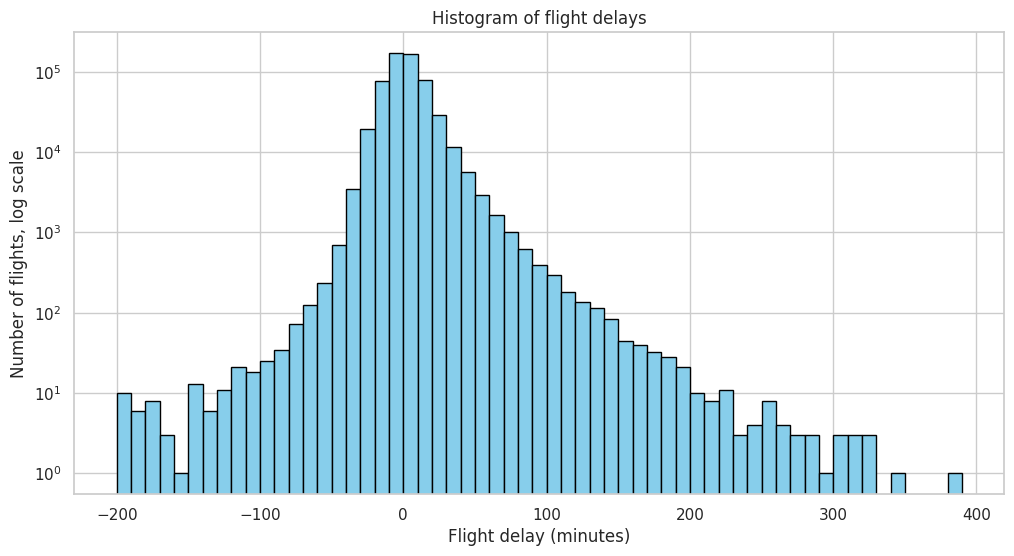

In [2]:
# Histogram of flight delays

flights_delay_minutes = flights_data['Flight delay'].dt.total_seconds() / 60

plt.figure(figsize=(12, 6))
plt.hist(flights_delay_minutes, bins=range(-200, 400, 10), color='skyblue', edgecolor='black')
plt.title('Histogram of flight delays')
plt.xlabel('Flight delay (minutes)')
plt.ylabel('Number of flights, log scale')
plt.yscale('log')
plt.show()

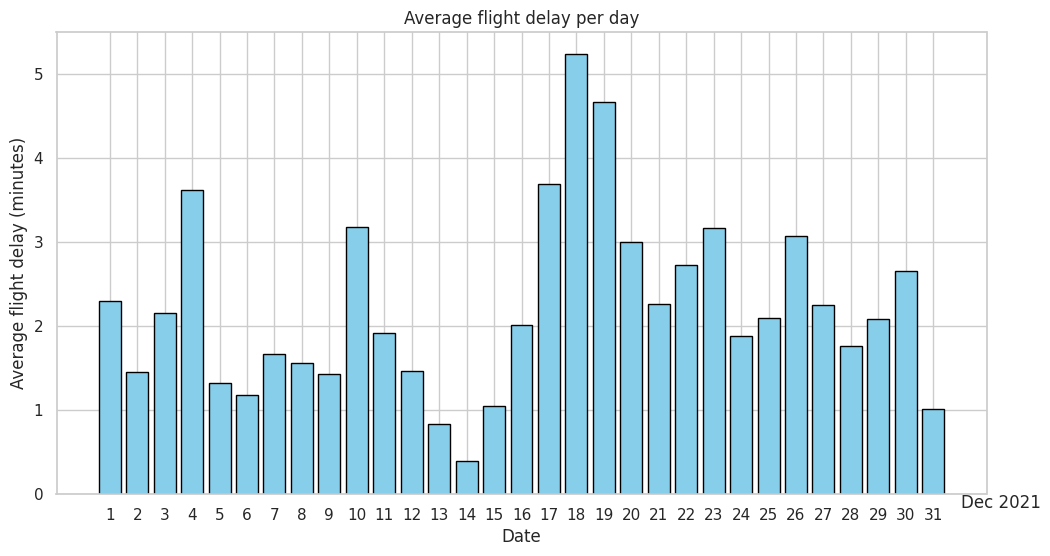

In [24]:
# Histogram of the delays per day
flights_data['FILED OFF BLOCK TIME'] = pd.to_datetime(flights_data['FILED OFF BLOCK TIME'])
daily_flights_delay = flights_data.groupby(flights_data['FILED OFF BLOCK TIME'].dt.date)['Flight delay'].mean().dt.total_seconds() / 60
plt.figure(figsize=(12, 6))
plt.bar(daily_flights_delay.index, daily_flights_delay, color='skyblue', edgecolor='black')
plt.title('Average flight delay per day')

# Formatting x-axis
# Extract just the day for the x-axis labels
day_labels = [date.day for date in daily_flights_delay.index]
plt.xticks(daily_flights_delay.index, labels=day_labels, rotation=0)

from datetime import timedelta# Adding month and year at the end of the x-axis
if len(daily_flights_delay.index) > 0:
    last_date = daily_flights_delay.index[-1]
    plt.text(last_date + timedelta(days=1), 0, last_date.strftime('%b %Y'), horizontalalignment='left', verticalalignment='top')



plt.xlabel('Date')
plt.ylabel('Average flight delay (minutes)')


plt.show()


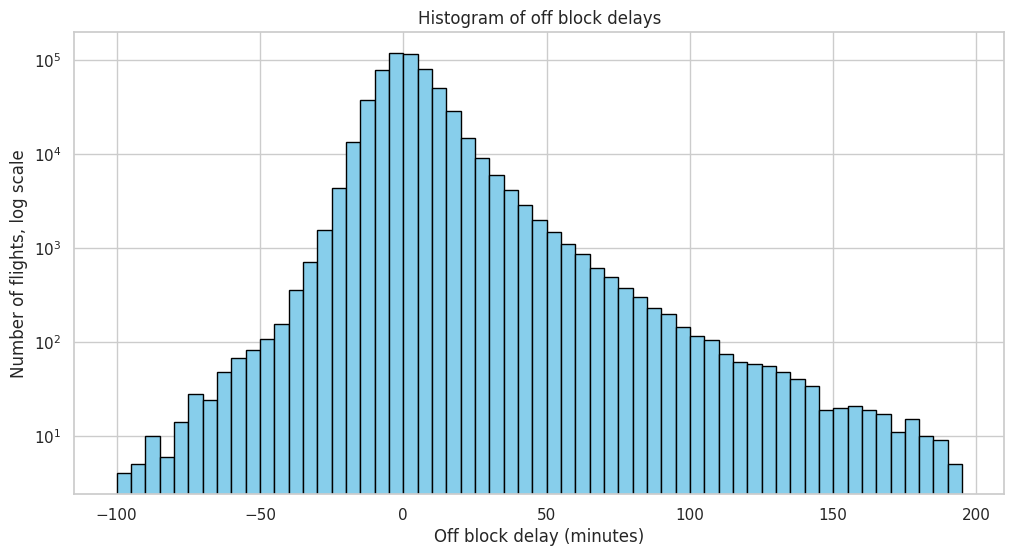

In [11]:
# Histogram of off block delay

off_block_delays_minutes = flights_data['Off block delay'].dt.total_seconds() / 60

plt.figure(figsize=(12, 6))
plt.hist(off_block_delays_minutes, bins=range(-100, 200, 5), color='skyblue', edgecolor='black')
plt.xlabel('Off block delay (minutes)')
plt.ylabel('Number of flights, log scale')
plt.title('Histogram of off block delays')
plt.yscale('log')
plt.show()

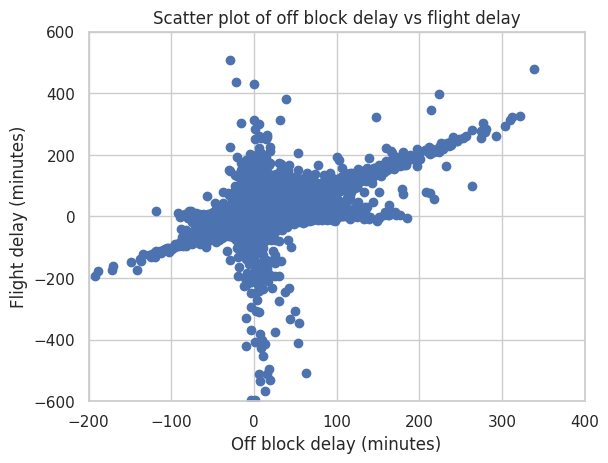

In [12]:
# scatter plot of off block delay vs flight delay

# plt.figure(figsize=(6, 8))
plt.scatter(off_block_delays_minutes, flights_delay_minutes)
plt.xlabel('Off block delay (minutes)')
plt.ylabel('Flight delay (minutes)')
plt.title('Scatter plot of off block delay vs flight delay')
# x and y axis limits
plt.xlim(-200, 400)
plt.ylim(-600, 600)
plt.show()



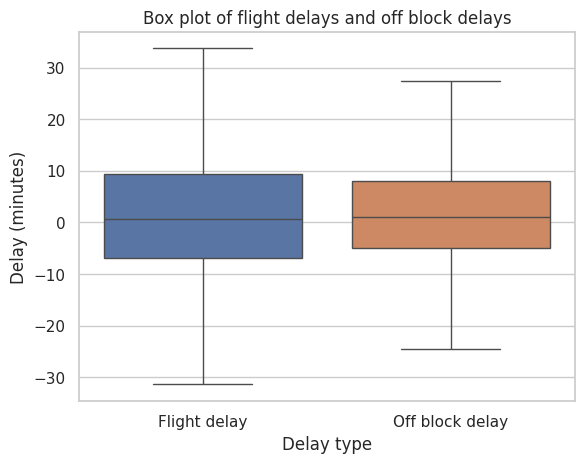

In [13]:
## Box plot of flight delays and off block delays (in one plot)

# Melt the DataFrame and convert 'off_block_delay' and 'delay' from timedelta to minutes
df_melted = pd.melt(
    flights_data,
    id_vars=['ECTRL ID'],
    value_vars=['Flight delay', 'Off block delay'],
    var_name='Delay type',
    value_name='Delay'
)

# Convert 'Delay' from timedelta to minutes
df_melted['Delay'] = df_melted['Delay'].dt.total_seconds() / 60

# Now you can use df_melted in your boxplot
# avoid outliers, use different colors for each boxplot
sns.boxplot(data=df_melted, x='Delay type', y='Delay', showfliers=False, hue='Delay type')
plt.title('Box plot of flight delays and off block delays')
plt.ylabel('Delay (minutes)')
plt.show()


### Flown distance

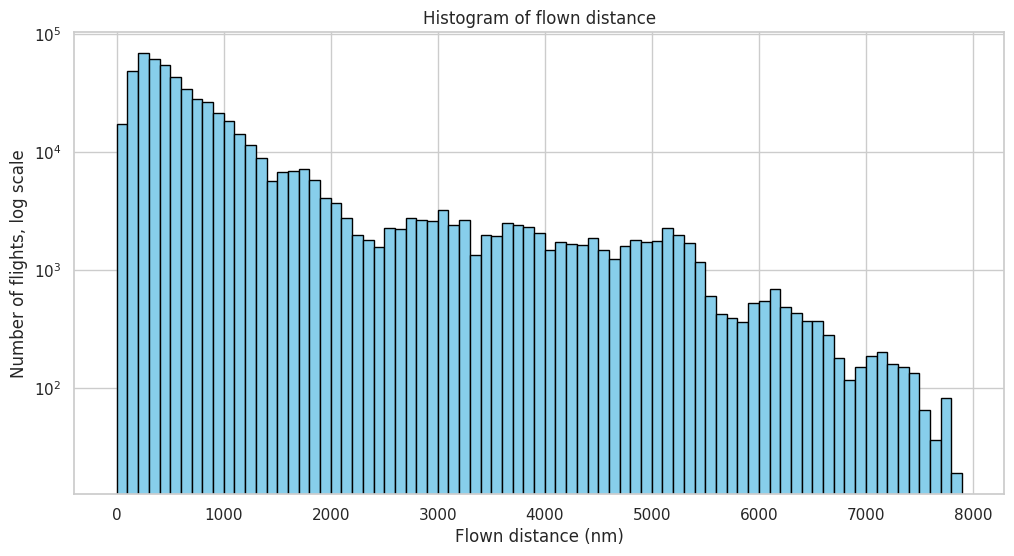

In [14]:
# Histogram of flown distance

plt.figure(figsize=(12, 6))
plt.hist(flights_data['Actual Distance Flown (nm)'], bins=range(0, 8000, 100), color='skyblue', edgecolor='black')
plt.title('Histogram of flown distance')
plt.xlabel('Flown distance (nm)')
plt.ylabel('Number of flights, log scale')
plt.yscale('log')
plt.show()

In [15]:
# the top 10 flights with the longest flown distance
top_10_flights = flights_data.nlargest(10, 'Actual Distance Flown (nm)')

# print flight ID, departure airport, destination airport, and the flown distance
print('Top 10 flights with the longest flown distance: \n', top_10_flights[["ECTRL ID", "ADEP", "ADES", "Actual Distance Flown (nm)"]].to_string(index=False))

# the lowest 20 flights with the shortest flown distance
bottom_20_flights = flights_data.nsmallest(20, 'Actual Distance Flown (nm)')
# print flight ID, departure airport, destination airport, and the flown distance
print('Bottom 20 flights with the shortest flown distance: \n', bottom_20_flights[["ECTRL ID", "ADEP", "ADES", "Actual Distance Flown (nm)"]].to_string(index=False))

Top 10 flights with the longest flown distance: 
  ECTRL ID ADEP ADES  Actual Distance Flown (nm)
248687509 KJFK WSSS                        9282
248664085 KJFK WSSS                        9224
248714646 KJFK WSSS                        9217
248724613 KJFK WSSS                        9176
248474217 KJFK WSSS                        9153
248620395 KJFK WSSS                        8995
248640684 KJFK WSSS                        8967
248593570 KJFK WSSS                        8966
248608866 KJFK WSSS                        8962
248355179 KJFK WSSS                        8853
Bottom 20 flights with the shortest flown distance: 
  ECTRL ID ADEP ADES  Actual Distance Flown (nm)
248153567 ENWA ZZZZ                           0
248214378 ENWV ZZZZ                           0
248243135 ENWV ZZZZ                           0
248275499 ZZZZ ZZZZ                           0
248319373 ZZZZ EHKD                           0
248328400 ZZZZ ZZZZ                           0
248376224 ZZZZ ZZZZ             

### Airport, aircraft

In [16]:

## Number of unique departure airports
num_dep_airports = len(flights_data['ADES'].unique())
print(f'Number of unique departure airports: {num_dep_airports}')

## Number of unique destination airports
num_dest_airports = len(flights_data['ADES'].unique())
print(f'Number of unique destination airports: {num_dest_airports}')

## Number of unique aircraft type
num_aircraft_types = len(flights_data['AC Type'].unique())
print(f'Number of unique aircraft types: {num_aircraft_types}')

## Number of unique aircraft operator
num_aircraft_operators = len(flights_data['AC Operator'].unique())
print(f'Number of unique aircraft operators: {num_aircraft_operators}')




Number of unique departure airports: 1400
Number of unique destination airports: 1400
Number of unique aircraft types: 220
Number of unique aircraft operators: 574


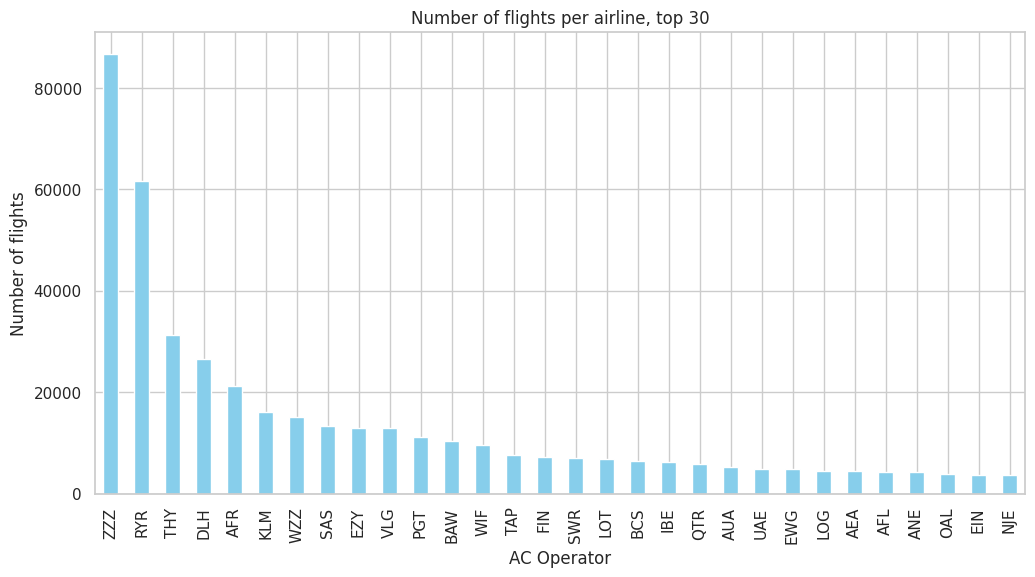

In [17]:
# Bar plot of the number of flights per airline

# Count the number of flights per airline
flights_per_airline = flights_data['AC Operator'].value_counts(sort=True) # sort the airlines by number of flights

# Plot the top airlines
plt.figure(figsize=(12, 6))
flights_per_airline.head(30).plot(kind='bar', color='skyblue')
plt.title('Number of flights per airline, top 30')
plt.ylabel('Number of flights')
plt.show()


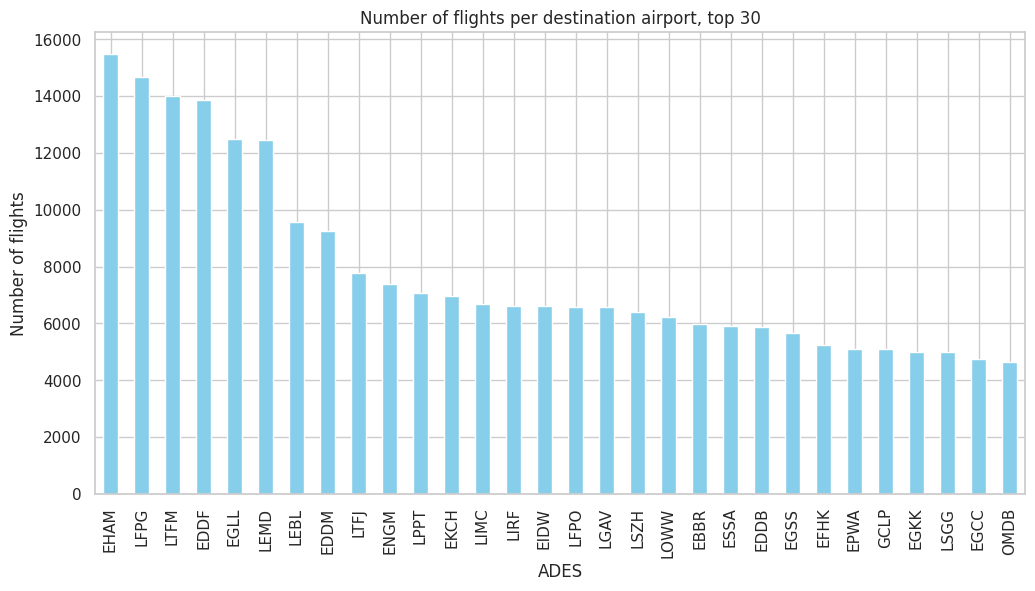

In [18]:
# Bar plot of the number of flights per destination airport

# Count the number of flights per destination airport
flights_per_destination = flights_data['ADES'].value_counts(sort=True) # sort the airports by number of flights

# Plot the top destination airports
plt.figure(figsize=(12, 6))
flights_per_destination.head(30).plot(kind='bar', color='skyblue')
plt.title('Number of flights per destination airport, top 30')
plt.ylabel('Number of flights')
plt.show()


### Others

In [73]:

## Number of flights
num_flights = len(flights_data)
print(f'Number of flights: {num_flights}')

## Number of flights with delay of 1 hour or more (difference between FILED ARRIVAL TIME and ACTUAL ARRIVAL TIME)

# ## Number of flights with delay more than 10 hours
# num_delays_10hr = len(flights_data[flights_data['delay'] > pd.Timedelta('10 hour')])
# print(f'Number of flights with delay by more than 10 hours: {num_delays_10hr}')

## Number of flights with delay less than 1 hour
num_delays_less_1hr = len(flights_data[(flights_data['Flight delay'] < pd.Timedelta('1 hour')) & (flights_data['Flight delay'] > pd.Timedelta('0 minute'))])
print(f'Number of flights with delay by less than 1 hour: {num_delays_less_1hr}')

# number of flights arrived exactly on time (to the second)
num_on_time_arrivals = len(flights_data[flights_data['Flight delay'] == pd.Timedelta('0 minute')])
print(f'Number of flights arrived exactly on time: {num_on_time_arrivals}')

## Number of flights arriving before scheduled time
num_early_arrivals = len(flights_data[flights_data['Flight delay'] < pd.Timedelta('0 minute')])
print(f'Number of flights arriving before scheduled time: {num_early_arrivals}')

# unit test: check if the sum of all the delay categories is equal to the total number of flights
assert num_flights == num_delays_1hr + num_delays_less_1hr + num_on_time_arrivals + num_early_arrivals
print(f'Unit test passed. Sum of all delay categories: \n delays of 1 hour or more ({num_delays_1hr}) + delays less than 1 hour ({num_delays_less_1hr}) + on time arrivals ({num_on_time_arrivals}) + early arrivals ({num_early_arrivals}) = {num_delays_1hr + num_delays_less_1hr + num_on_time_arrivals + num_early_arrivals} \nis equal to the total number of flights {num_flights}')

Number of flights: 570200
Number of flights with delay by 1 hour or more: 4712
Number of flights with delay by less than 1 hour: 294395
Number of flights arrived exactly on time: 1099
Number of flights arriving before scheduled time: 269994
Unit test passed. Sum of all delay categories: 
 delays of 1 hour or more (4712) + delays less than 1 hour (294395) + on time arrivals (1099) + early arrivals (269994) = 570200 
is equal to the total number of flights 570200


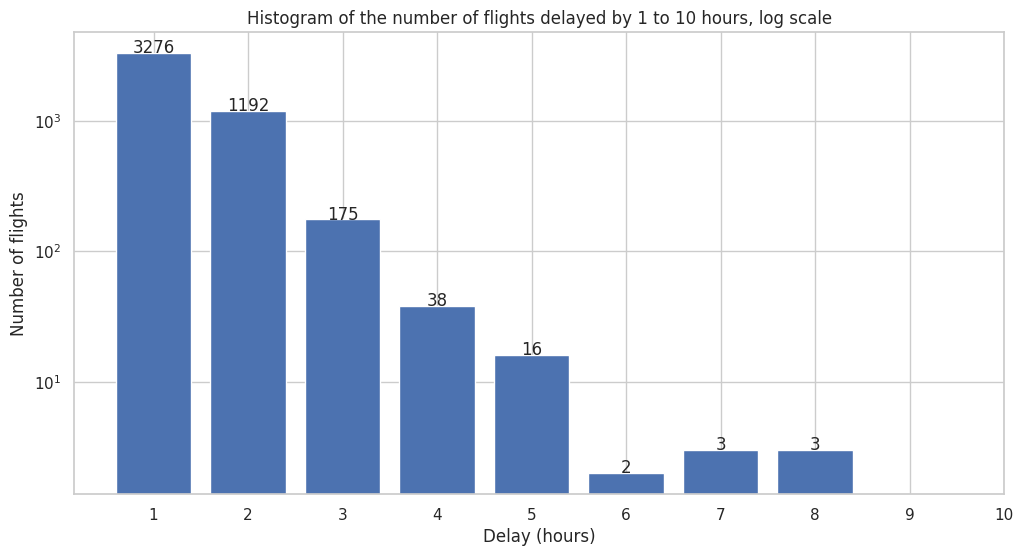

In [74]:
# Histogram of the number of flights delayed by  1 hour, 2 hours, 3 hours, 4 hours, 5 hours, 6 hours, 7 hours, 8 hours, 9 hours, 10 hours
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

delays = flights_data['delay'].dt.total_seconds() / 3600
delays = delays[delays > 1]
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(delays, bins=np.arange(0.5, 10.5, 1), rwidth=0.8)
plt.xlabel('Delay (hours)')
plt.ylabel('Number of flights')
plt.title('Histogram of the number of flights delayed by 1 to 10 hours, log scale')
plt.xticks(np.arange(1, 11)) 
plt.yscale('log')

# Annotate the bars with the counts
for count, bin in zip(counts, bins):
    plt.annotate(str(int(count)), (bin + 0.5, count), textcoords="offset points", xytext=(0,0), ha='center')

plt.show()

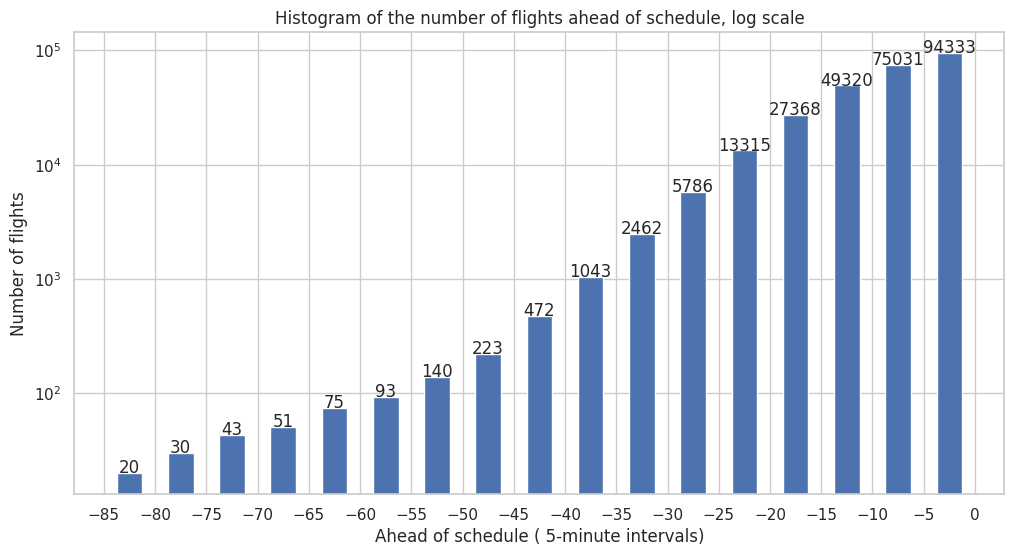

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

# Select flights that are ahead of schedule, in minutes
ahead_of_schedule = flights_data['delay'].dt.total_seconds() / 60
ahead_of_schedule = ahead_of_schedule[ahead_of_schedule < 0]

plt.figure(figsize=(12, 6))

# Create bins in 5-minute intervals
bins = np.arange(-85, 0.5, 5)

counts, bins, _ = plt.hist(ahead_of_schedule, bins=bins, rwidth=0.5)
plt.xlabel('Ahead of schedule ( 5-minute intervals)')
plt.ylabel('Number of flights')
plt.title('Histogram of the number of flights ahead of schedule, log scale')
plt.xticks(bins)
# plt.xticks(np.arange(-20, 0, 5))
plt.yscale('log')

# # Annotate the bars with the counts
for count, bin in zip(counts, bins):
    plt.annotate(str(int(count)), (bin + 2.5, count), textcoords="offset points", xytext=(0,0), ha='center')

plt.show()

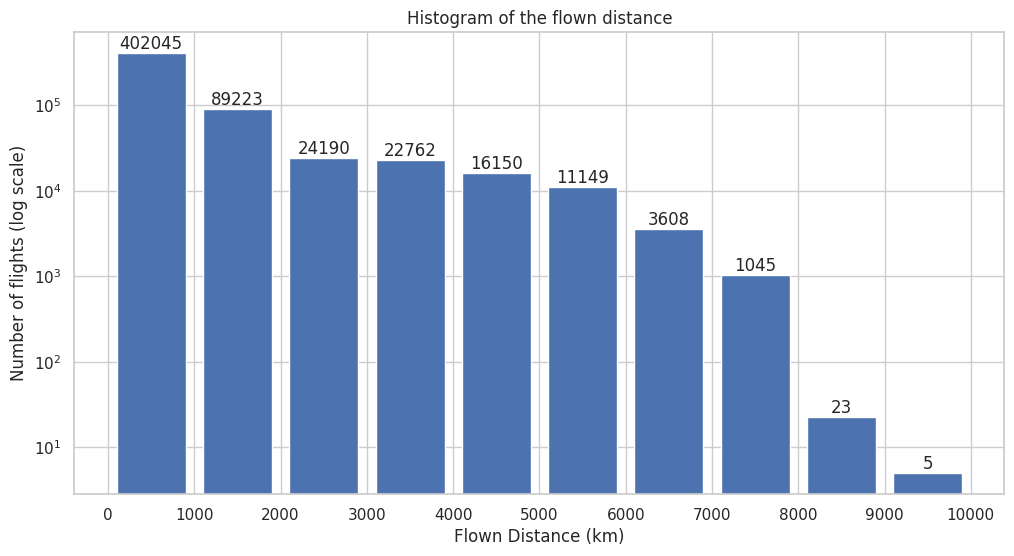

In [51]:

# Flown distance: plot a histogram of the flown distance
plt.figure(figsize=(12, 6))
flown_distance = flights_data['Actual Distance Flown (nm)']

# Define bin edges
bins = np.arange(0, flown_distance.max() + 1000, 1000)

# Plot histogram
counts, _, _ = plt.hist(flown_distance, bins=bins, rwidth=0.8)

# Annotate bars
for x, y in zip(bins, counts):
    if y != 0:
        plt.text(x + 500, y, str(int(y)), ha='center', va='bottom')

# Set x-ticks
plt.xticks(bins)

plt.yscale('log')
plt.xlabel('Flown Distance (km)')
plt.ylabel('Number of flights (log scale)')
plt.title('Histogram of the flown distance')
plt.show()